In [119]:
import os
import pandas as pd

# Define the folder path and output file
folder_path = '/Users/debnathshoham/Downloads/Index Fund Time series'  # Update this to the folder containing your CSV files
output_file = 'collated_prices.csv'  # Output CSV file name

# Initialize an empty DataFrame to hold the collated data
collated_df = pd.DataFrame()

# Loop through each CSV file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file, assuming it contains 'Date' and 'Price' columns
        # Specify dayfirst=True to interpret 'DD/MM/YY' format correctly
        df = pd.read_csv(file_path, usecols=['Date', 'Price'], dayfirst=True, parse_dates=['Date'])
        
        # Rename the 'Price' column to the file name (without extension)
        df.rename(columns={'Price': file_name.split('.')[0]}, inplace=True)
        
        # Merge this file's data with the collated DataFrame
        if collated_df.empty:
            # If the collated DataFrame is empty, initialize it with the first file's data
            collated_df = df
        else:
            # Otherwise, merge on 'Date'
            collated_df = pd.merge(collated_df, df, on='Date', how='outer')

# Save the collated DataFrame to a new CSV file
collated_df.to_csv(output_file, index=False)

print(f"Collated CSV saved as {output_file}")


Collated CSV saved as collated_prices.csv


In [120]:
assets = pd.read_csv('collated_prices.csv', index_col='Date', parse_dates=True,
                           dtype=float, thousands=",", header=0)
#assets.bfill(inplace=True)

In [121]:
assets2 = assets.loc["2019-01-02":"2024-09-01"]

In [125]:
assets2.loc["2019-01-02"]

Nifty Microcap 250 Historical Data                     NaN
Nifty Midcap 150 Historical Data                       NaN
Gold                                              1290.500
Nifty Auto Historical Data                        8902.650
Nifty Midcap 50 Historical Data                   4860.050
Nifty 50 Historical Data                         10792.500
Nifty Bank Historical Data                       27174.700
Nifty Alpha Low-Volatility 30 Historical Data          NaN
S&P BSE 250 LargeMidCap Historical Data           4360.300
2yearBond                                            6.989
Nifty 500 Historical Data                         9103.400
Nifty Alpha 50 Historical Data                   12108.150
gold2                                             1290.500
10yearBond                                           7.354
Nifty India Manufacturing Historical Data              NaN
Nifty 100 Historical Data                              NaN
Name: 2019-01-02 00:00:00, dtype: float64

In [128]:
asset_prices = assets2.iloc[:, [3,4,5,6,10,11,12]]

In [130]:
asset_prices.bfill(inplace=True)

/var/folders/x3/xx_ygsk93yd43p3xc2z0wjz80000gn/T/ipykernel_3145/1456596871.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Function to calculate CAGR
def calculate_cagr(price_series):
    start_value = price_series[0]
    end_value = price_series[-1]
    num_years = len(price_series) / 252  # Assuming 252 trading days in a year
    cagr = (end_value / start_value) ** (1 / num_years) - 1
    return cagr

# Function to calculate Maximum Drawdown
def calculate_max_drawdown(price_series):
    cumulative_return = price_series / price_series[0]
    peak = np.maximum.accumulate(cumulative_return)  # Use numpy's accumulate function to find the peak
    drawdown = (cumulative_return - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

# Function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.08):
    excess_returns = returns - risk_free_rate
    avg_excess_return = np.mean(excess_returns)
    return_volatility = np.std(excess_returns)
    sharpe_ratio = avg_excess_return / return_volatility
    return sharpe_ratio

def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def risk_constraint(weights, cov_matrix, risk_limit):
    return risk_limit - np.sqrt(portfolio_variance(weights, cov_matrix))

def calculate_cov_matrix_from_timeseries(asset_prices):
    asset_returns = asset_prices.pct_change(fill_method=None).dropna()
    cov_matrix = asset_returns.cov()
    
    return cov_matrix

def optimize_portfolio(cov_matrix, risk_limit, n_assets):
    initial_weights = np.ones(n_assets) / n_assets

    # Constraints (sum of weights = 1 and risk limit)
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights is 1
        {'type': 'ineq', 'fun': lambda weights: risk_constraint(weights, cov_matrix, risk_limit)}  # Risk limit
    ]
    
    # Bounds (no short selling, i.e., weights >= 0)
    bounds = [(0, 1) for _ in range(n_assets)]
    
    # Minimize the objective function
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), 
                      method='SLSQP', constraints=constraints, bounds=bounds)
    
    print(result.message)
    return result.x if result.success else None

def optimized_portfolio_time_series(asset_prices, weights):
    return (weights*asset_prices).sum(axis=1).to_frame("Portfolio Price")


<Axes: xlabel='Date'>

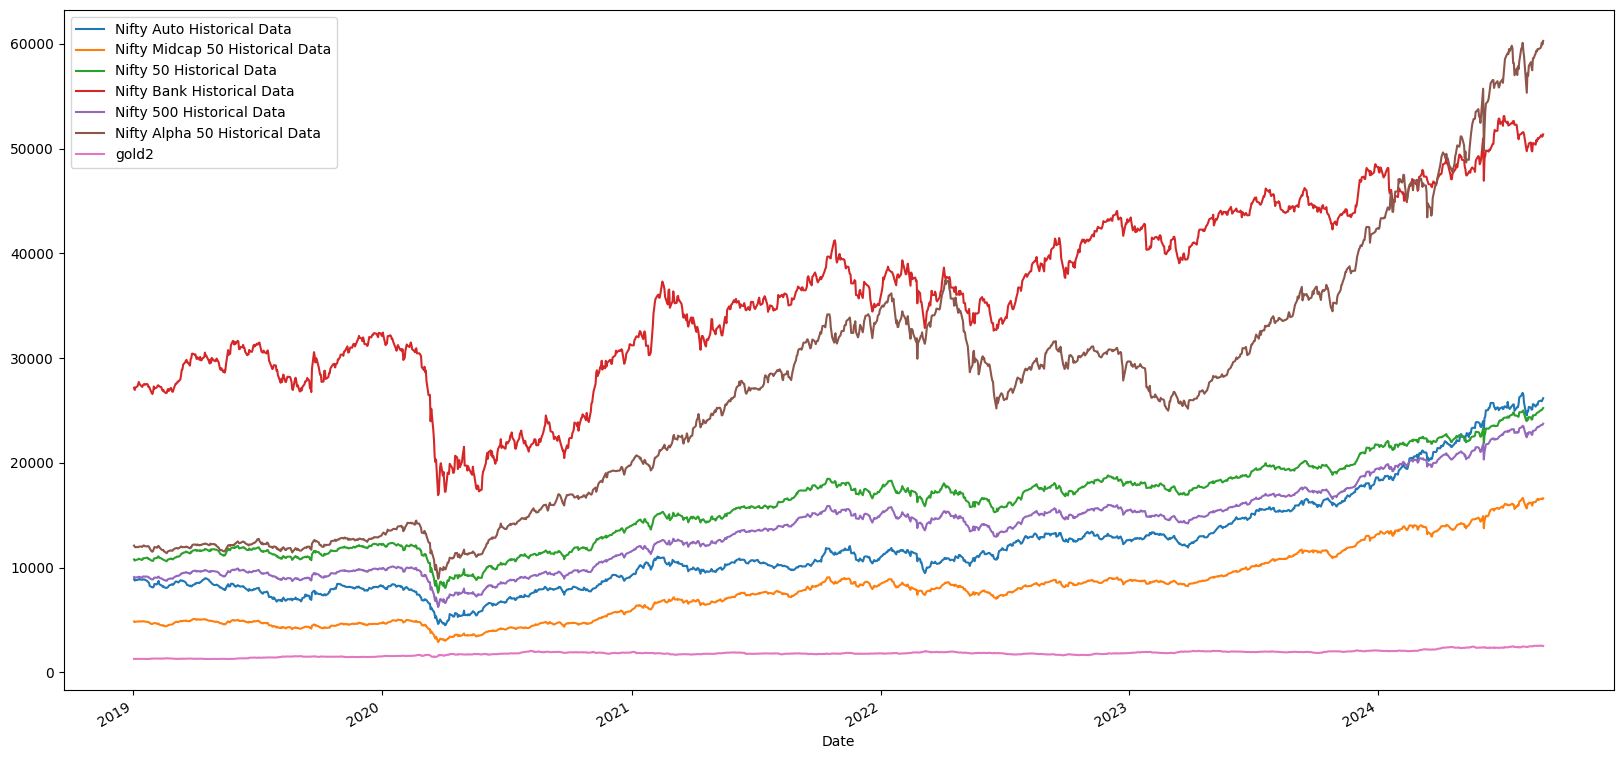

In [131]:
asset_prices.plot(figsize=(20,10))

In [134]:
asset_prices_100 = asset_prices/asset_prices.iloc[0]*100

In [140]:
asset_prices = asset_prices_100
cov_matrix = calculate_cov_matrix_from_timeseries(asset_prices)
print(f"Risk Limit = {risk_limit}")
# Optimize portfolio weights
optimal_weights = optimize_portfolio(cov_matrix, risk_limit, asset_prices.shape[1])

print("Optimal Weights:", optimal_weights)

folio_time_series = optimized_portfolio_time_series(asset_prices, optimal_weights).values

print(f"CAGR = {calculate_cagr(folio_time_series)}")
print(f"Max drawdown = {calculate_max_drawdown(folio_time_series)}")

print(f"Sharpe Ratio = {calculate_sharpe_ratio(folio_time_series)}")

print(f"Portfolio Stdev = {np.sqrt(portfolio_variance(optimal_weights, calculate_cov_matrix_from_timeseries(asset_prices)))}")

Risk Limit = 0.15
Optimization terminated successfully
Optimal Weights: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
CAGR = [0.19749523]
Max drawdown = -0.3424058940670495
Sharpe Ratio = 3.104717853636484
Portfolio Stdev = 0.010617175494539655


In [147]:
asset_prices_100.to_clipboard()

In [148]:
pd.DataFrame(folio_time_series).to_clipboard()

In [135]:
def create_folio(risk_limit=0.1, year_from = "2023", to_print=["weights", "cagr", "max_drawdown", "sharpe_ratio", "portfolio_variance"]):
    #asset_prices = assets.loc[year_from:]
    asset_prices = asset_prices_100
    cov_matrix = calculate_cov_matrix_from_timeseries(asset_prices)
    print(f"Risk Limit = {risk_limit}")
    # Optimize portfolio weights
    optimal_weights = optimize_portfolio(cov_matrix, risk_limit, asset_prices.shape[1])
    if "weights" in to_print:
        print("Optimal Weights:", optimal_weights)

    folio_time_series = optimized_portfolio_time_series(asset_prices, optimal_weights).values

    if "cagr" in to_print:
        print(f"CAGR = {calculate_cagr(folio_time_series)}")
    if "max_drawdown" in to_print:
        print(f"Max drawdown = {calculate_max_drawdown(folio_time_series)}")
    if "sharpe_ratio" in to_print:
        print(f"Sharpe Ratio = {calculate_sharpe_ratio(folio_time_series)}")
    if "portfolio_variance" in to_print:
        print(f"Portfolio Stdev = {np.sqrt(portfolio_variance(optimal_weights, calculate_cov_matrix_from_timeseries(asset_prices)))}")
    print("--------------------------------------------------------")
    

In [137]:
for i in np.arange(0.001, 0.5, 0.05):
    create_folio(risk_limit=i, to_print=["cagr", "max_drawdown", "sharpe_ratio", "portfolio_variance"])

Risk Limit = 0.001
Positive directional derivative for linesearch


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [64]:
df_folio = (optimal_weights*asset_prices).sum(axis=1).to_frame("Portfolio Price")

In [65]:
import plotly.express as px
def plot_portfolio_prices(portfolio_prices_df):
    fig = px.line(portfolio_prices_df, 
                  x=portfolio_prices_df.index, 
                  y='Portfolio Price', 
                  title="Portfolio Price Time Series", 
                  labels={"Portfolio Price": "Price", "index": "Date"})
    fig.show()

<Axes: xlabel='Date'>

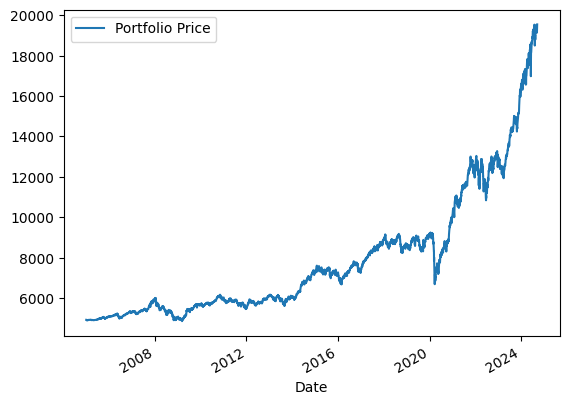

In [72]:
df_folio.plot()